## Contraction

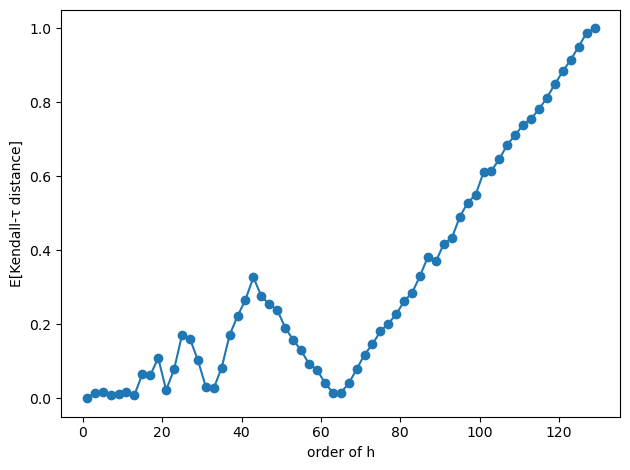

In [1]:
MODULE_NAME = "nurs"
n = 200
M = 7
orders_to_try = [m for m in range(1, 130, 2)]
reps_per_order = 1000
rng_seed = 38219

import math, importlib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display
from distance import dist, inv, DIST_NAME_TO_ID

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)

mod = importlib.import_module(MODULE_NAME)
sample_unif = mod.sample_unif
_sample_eta_fixed_order = mod.sample_eta_fixed_order

rng = np.random.default_rng(rng_seed)
index_cache = None
dist_id_tau = DIST_NAME_TO_ID["inv"]

def energy_cycle_spearman(sigma, eta, period):
    global index_cache
    n = sigma.size
    if index_cache is None or index_cache.size != n:
        index_cache = np.arange(n, dtype=np.int64)
    E = np.empty(period, float)
    cur = sigma.copy()
    for j in range(period):
        diff = cur - index_cache
        E[j] = float(np.dot(diff, diff))
        cur = cur[eta]
    return E

def logsumexp(x):
    m = np.max(x)
    return -np.inf if np.isneginf(m) else float(m + np.log(np.sum(np.exp(x - m))))

def counts_for_windows(period, m, a):
    q, r = divmod(a, period)
    c1 = np.full(period, q, np.int64)
    if r > 0: c1[np.arange(r)] += 1
    c2 = np.full(period, q, np.int64)
    if r > 0: c2[(np.arange(r) + m) % period] += 1
    return c1, c2

def probs_from_logweights_counts(logw, c):
    mask = c > 0
    if not np.any(mask):
        p = np.full_like(logw, 1.0 / logw.size, float)
        return p, 0.0
    g = np.full_like(logw, -np.inf, float)
    g[mask] = logw[mask] + np.log(c[mask].astype(float))
    Z = logsumexp(g)
    p = np.exp(g - Z)
    s = p.sum()
    if s > 0: p /= s
    else: p[:] = 1.0 / logw.size
    return p, Z

def sample_idx(p, rng):
    return int(np.searchsorted(np.cumsum(p), rng.random(), side="right"))

def sample_shift_coupling_exact(p, q, m, rng):
    s = np.minimum(p, q); s_sum = float(s.sum())
    u = rng.random()
    if s_sum > 0 and u <= s_sum:
        r = sample_idx(s / s_sum, rng)
        return r, r, s_sum, 1
    p_res = p - s
    q_res = q - s
    t = np.minimum(p_res, np.roll(q_res, -m))
    t_sum = float(t.sum())
    v = rng.random() * (1.0 - s_sum)
    if t_sum > 0 and v <= t_sum:
        r = sample_idx(t / t_sum, rng)
        return r, (r + m) % p.size, s_sum + t_sum, 2
    p_left = p_res - t
    q_left = q_res - np.roll(t, m)
    sp = float(p_left.sum()); sq = float(q_left.sum())
    rx = sample_idx((p_left / sp) if sp > 0 else p, rng)
    ry = sample_idx((q_left / sq) if sq > 0 else q, rng)
    return rx, ry, s_sum + t_sum, 3

def perm_power(perm, k):
    n = perm.size; k = int(k)
    if k == 0: return np.arange(n, dtype=np.int64)
    result = np.arange(n, dtype=np.int64); base = perm.copy()
    while k > 0:
        if k & 1: result = result[base]
        base = base[base]
        k >>= 1
    return result

def compose_right(a, b):
    return a[b]

def is_adjacent_transposition(tau):
    n = tau.size
    diff = np.where(tau != np.arange(n, dtype=np.int64))[0]
    if diff.size != 2: return False, -1
    i, j = int(diff[0]), int(diff[1])
    if j != i + 1: return False, -1
    return (tau[i] == i + 1 and tau[i + 1] == i), i

def verify_eta_in_Omegai(eta, m):
    n = eta.size
    tau = perm_power(eta, m)
    ok, i = is_adjacent_transposition(tau)
    if not ok: 
        raise RuntimeError("η^m is not an adjacent transposition.")
    if not np.all(perm_power(eta, 2 * m) == np.arange(n, dtype=np.int64)):
        raise RuntimeError("η^{2m} is not identity.")
    tau_i = np.arange(n, dtype=np.int64); tau_i[i], tau_i[i+1] = i+1, i
    h = compose_right(tau_i, eta)  # h = τ_i ∘ η
    seen = np.zeros(n, dtype=bool)
    for s in range(n):
        if seen[s]: continue
        t = s
        while not seen[t]:
            seen[t] = True; t = int(h[t])
    if h[i] != i or h[i+1] != i+1:
        raise RuntimeError("h moves i or i+1.")
    return i

def sample_eta_in_Omegai(n, L_target, rng, max_tries=40):
    for _ in range(max_tries):
        eta, m = _sample_eta_fixed_order(n=n, L_target=L_target, rng=rng)
        try:
            i = verify_eta_in_Omegai(eta, int(m))
            return eta, int(m), i
        except Exception:
            continue
    raise RuntimeError("Failed to sample η∈Ω_i with required order.")

def precompute_tau_powers(eta, period):
    n = eta.size
    out = np.empty(period, dtype=np.float64)
    cur = np.arange(n, dtype=np.int64)
    out[0] = 0.0
    for k in range(1, period):
        cur = cur[eta]
        out[k] = float(dist(dist_id_tau, cur))
    return out

def one_trial(n, eta, period, m, beta, c1, c2, tau_cache, rng):
    sigma = sample_unif(n)
    logw = -beta * energy_cycle_spearman(sigma, eta, period)
    p, _ = probs_from_logweights_counts(logw, c1)
    q, _ = probs_from_logweights_counts(logw, c2)
    rx, ry, _, step = sample_shift_coupling_exact(p, q, m, rng)
    delta = (ry - rx) % period
    d_tau = 0.0 if rx == ry else tau_cache[delta]
    if step == 2:
        if delta != m: raise RuntimeError("Step-2 mismatch not at shift m.")
        if int(d_tau) != 1: raise RuntimeError("Step-2 mismatch does not have Kendall–τ distance 1.")
    return d_tau, (step == 1), (step == 2), (step == 3)

def run(n, orders, M, reps, rng):
    a = 1 << M
    Dmax_tau = n * (n - 1) // 2
    E_max = (n**3 - n) / 3.0
    L_E = 2.0 * (n - 1)
    rows = []
    for m_req in orders:
        eta, m_use, i = sample_eta_in_Omegai(n=n, L_target=m_req, rng=rng)
        period = 2 * m_use
        c1, c2 = counts_for_windows(period, m_use, a)
        s_mult = int(np.minimum(c1, c2).sum())
        s0 = s_mult / a
        beta1 = s_mult / (2.0 * a * E_max)
        beta2 = s_mult / (2.0 * a * (Dmax_tau - 1) * L_E)
        beta = min(beta1, beta2)
        tau_cache = precompute_tau_powers(eta, period)
        if int(tau_cache[m_use]) != 1: 
            raise RuntimeError("Verification failed: inv(η^m) != 1.")
        dTau = np.empty(reps, float)
        s1 = s2 = s3 = 0
        for t in range(reps):
            a2, b1, b2, b3 = one_trial(n, eta, period, m_use, beta, c1, c2, tau_cache, rng)
            dTau[t] = a2
            s1 += int(b1); s2 += int(b2); s3 += int(b3)
        rows.append({
            "n": n, "a": a, "order_L_target": m_req, "order_L_used": m_use, "i": i, "ord_eta": period,
            "overlap_mult": s_mult, "s0": s0,
            "beta": beta, "beta_bound1": beta1, "beta_bound2": beta2,
            "E_tau_mean": float(dTau.mean()),
            "E_tau_sd": float(dTau.std(ddof=1)) if reps > 1 else float("nan"),
            "rate_step1": s1 / reps, "rate_step2": s2 / reps, "rate_step3": s3 / reps,
        })
    cols = ["order_L_target","order_L_used","i","ord_eta","a","overlap_mult","s0","beta","beta_bound1","beta_bound2",
            "E_tau_mean","E_tau_sd","rate_step1","rate_step2","rate_step3","n"]
    return pd.DataFrame(rows)[cols].sort_values("order_L_target").reset_index(drop=True)

res = run(n, orders_to_try, M, reps_per_order, rng)

plt.rcParams.update({"axes.grid": False})

fig, ax = plt.subplots()
ax.plot(res["order_L_used"], res["E_tau_mean"], marker="o")
ax.set_xlabel("order of h")
ax.set_ylabel("E[Kendall-τ distance]")
ax.grid(False)

plt.tight_layout()
plt.show()

## ESS

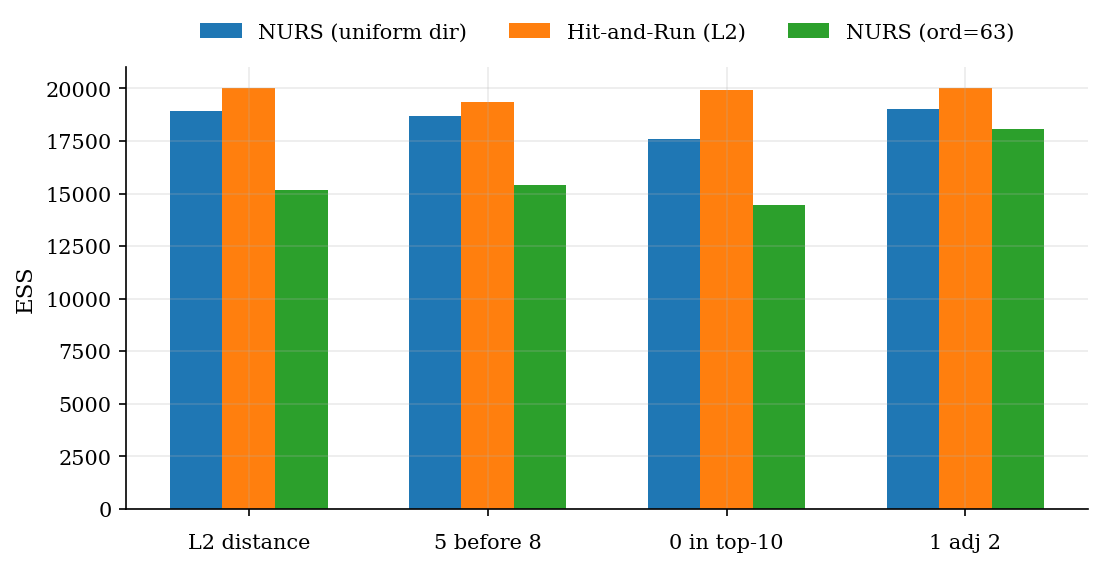

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
from distance import DIST_NAME_TO_ID
import nurs
import hit_run
import random

def _apply_style():
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "figure.figsize": (7.5, 4.75),
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.frameon": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
    })

def ess_1d(x):
    N = len(x)
    x = np.asarray(x, dtype=float)
    x -= x.mean()
    var = (x**2).mean()
    if var == 0.0:
        return 0.0
    fft = np.fft.fft(np.concatenate([x, np.zeros_like(x)]))
    acov = np.fft.ifft(fft * np.conjugate(fft)).real[:N] / N
    rho = acov / var
    tau = 0.0
    k = 1
    while k + 1 < N and (rho[k] + rho[k + 1]) > 0.0:
        tau += rho[k] + rho[k + 1]
        k += 2
    return N / (1 + 2 * tau)

def _zero_based(s):
    s = np.asarray(s)
    if s.min() == 1 and s.max() == len(s):
        return s - 1
    return s

def l2_distance(s):
    s0 = _zero_based(s)
    return np.linalg.norm(s0 - np.arange(len(s0), dtype=s0.dtype))

def pos_vector(s):
    s0 = _zero_based(s)
    p = np.empty_like(s0)
    p[s0] = np.arange(len(s0))
    return p

if __name__ == "__main__":
    n = 200
    beta = 1.0 / (n**3)
    steps = 20_000
    chains = 1
    eps = 1e-3
    max_doublings = 7
    dist_id = DIST_NAME_TO_ID["L2"]
    rng_seed = 0
    np.random.seed(rng_seed)
    random.seed(rng_seed)
    rng_eta = np.random.default_rng(rng_seed)

    def make_step_nurs_uniform_dir():
        def _step(s):
            rho_arr = nurs.sample_unif(n)
            return nurs.nurs_kernel(
                n=n,
                start_perm=np.asarray(s, dtype=np.int64),
                beta=beta,
                eps=eps,
                max_doublings=max_doublings,
                rho=rho_arr,
                dist_id=dist_id,
            )
        return _step

    def make_step_hit_and_run():
        def _step(s):
            sigma1 = np.asarray(s, dtype=np.int64) + 1
            tau1 = hit_run.hit_and_run_L2_step(sigma1.tolist(), beta)
            return np.asarray(tau1, dtype=np.int64) - 1
        return _step

    def make_step_nurs_fixed_order(L):
        def _step(s):
            rho_arr, _ = nurs.sample_eta_fixed_order(n=n, L_target=L, rng=rng_eta)
            return nurs.nurs_kernel(
                n=n,
                start_perm=np.asarray(s, dtype=np.int64),
                beta=beta,
                eps=eps,
                max_doublings=max_doublings,
                rho=rho_arr,
                dist_id=dist_id,
            )
        return _step

    kernels = {
        "NURS (uniform dir)": make_step_nurs_uniform_dir(),
        "Hit-and-Run (L2)": make_step_hit_and_run(),
        "NURS (ord=63)": make_step_nurs_fixed_order(63),
    }

    warm_state = np.arange(n, dtype=np.int64)
    for f in kernels.values():
        _ = f(warm_state)

    def _update_traces(traces, state, t):
        traces["L2 distance"][t] = l2_distance(state)
        p = pos_vector(state)
        traces["5 before 8"][t] = int(p[5] < p[8])
        traces["0 in top-10"][t] = int(p[0] < 10)
        traces["1 adj 2"][t] = int(abs(p[1] - p[2]) == 1)

    stat_names = ["L2 distance", "5 before 8", "0 in top-10", "1 adj 2"]

    results = {}
    for kname, step in kernels.items():
        ess_accum = {sname: [] for sname in stat_names}
        for _ in range(chains):
            state = np.arange(n, dtype=np.int64)
            traces = {sname: np.empty(steps) for sname in stat_names}
            for t in range(steps):
                state = step(state)
                _update_traces(traces, state, t)
            for sname in stat_names:
                ess_accum[sname].append(ess_1d(traces[sname]))
        results[kname] = {sname: float(np.mean(vals)) for sname, vals in ess_accum.items()}

    _apply_style()
    x = np.arange(len(stat_names))
    klist = list(results.keys())
    W = 0.22
    offsets = np.linspace(-(len(klist) - 1) / 2, (len(klist) - 1) / 2, len(klist)) * W

    fig, ax = plt.subplots()
    for o, kname in zip(offsets, klist):
        vals = [results[kname][s] for s in stat_names]
        ax.bar(x + o, vals, width=W, label=kname)

    ax.set_xticks(x)
    ax.set_xticklabels(stat_names)
    ax.tick_params(axis='x', which='major', pad=8, labelrotation=0)

    ax.set_ylabel("ESS")
    ax.margins(y=0.05)

    ax.legend(loc="upper center",
            bbox_to_anchor=(0.5, 1.12),
            ncol=len(klist),
            borderaxespad=0.0)

    fig.subplots_adjust(top=0.82, bottom=0.20, right=0.98)

    plt.show()

## Index Plots

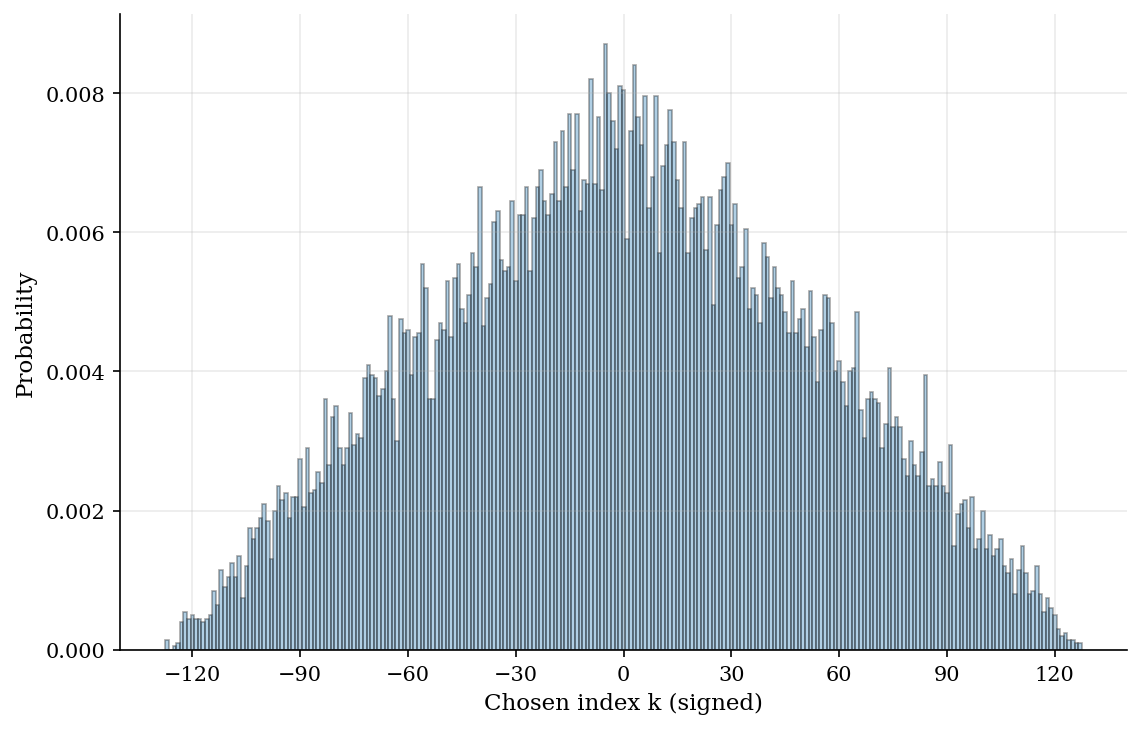

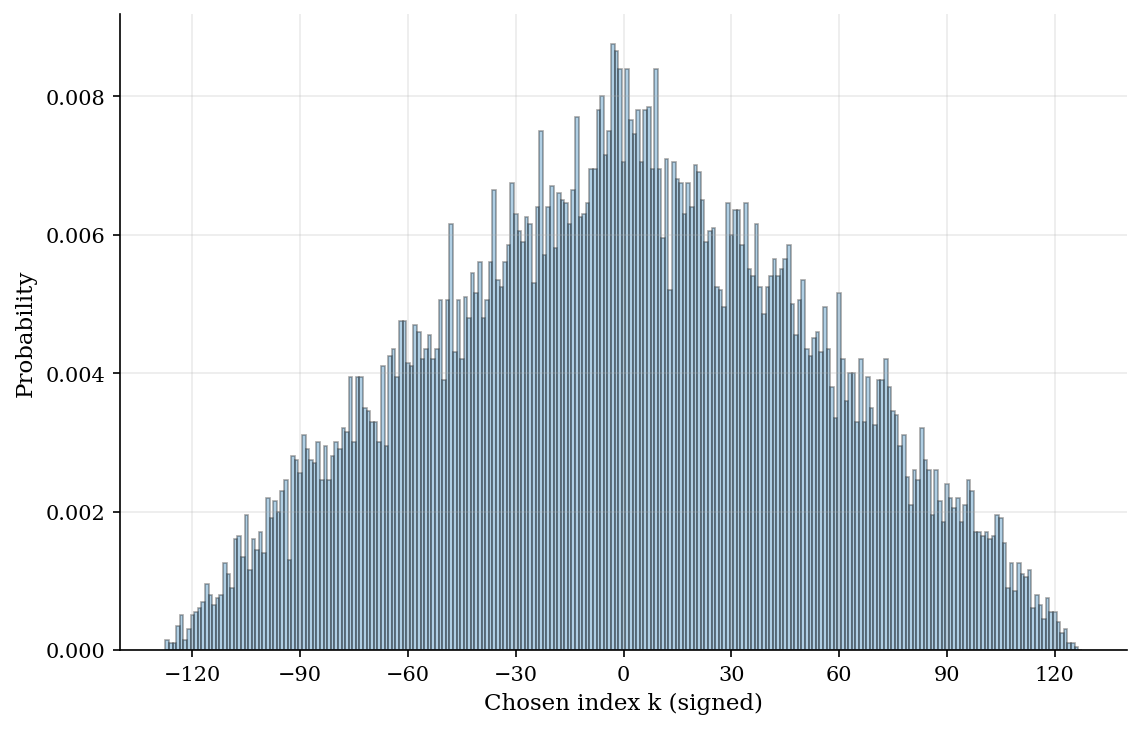

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from nurs import logsumexp2, sub_block_stops_log, apply_perm, sample_eta_fixed_order, sample_unif
from distance import dist, invert, DIST_NAME_TO_ID

def _apply_pub_style():
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "figure.figsize": (7.5, 4.75),
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.frameon": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
    })

def nurs_kernel_chosen_index(n, start, beta, eps, max_doublings, rho, dist_id):
    leps = math.log(eps)
    left = start.copy(); right = start.copy(); best = start.copy()
    best_chosen_idx = 0
    tot = -beta * dist(dist_id, start)
    fwd = rho; bwd = invert(fwd)
    lpos = 0; rpos = 0
    perm_buffer = np.empty(n, dtype=np.int64)
    doubling_bits = np.random.randint(0, 2, size=max_doublings)
    for j in range(max_doublings):
        ext = 1 << j
        grow = doubling_bits[j] == 1
        anchor = right if grow else left
        anchor_off = rpos if grow else lpos
        step = fwd if grow else bwd
        perm = anchor.copy()
        ext_logw = np.empty(ext, dtype=np.float64)
        for t in range(ext):
            apply_perm(perm_buffer, perm, step)
            perm, perm_buffer = perm_buffer, perm
            ext_logw[t] = -beta * dist(dist_id, perm)
        if sub_block_stops_log(ext_logw, leps):
            break
        last = perm.copy()
        perm = anchor.copy()
        for t in range(ext):
            apply_perm(perm_buffer, perm, step)
            perm, perm_buffer = perm_buffer, perm
            pos = anchor_off + (t + 1) if grow else anchor_off - (t + 1)
            lw = ext_logw[t]
            nt = logsumexp2(tot, lw)
            if np.random.random() < math.exp(min(0.0, lw - nt)):
                best = perm.copy()
                best_chosen_idx = pos
            tot = nt
        if grow:
            right = last; rpos += ext
        else:
            left = last; lpos -= ext
        if max(-beta * dist(dist_id, left), -beta * dist(dist_id, right)) <= leps + tot:
            break
    return best, best_chosen_idx

def sample_chosen_index_with_draw(n, sigma0, draw_rho, beta, eps, max_doublings, dist_id):
    s0 = np.fromiter(sigma0, dtype=np.int64, count=n)
    rho = draw_rho()
    nxt, chosen_idx = nurs_kernel_chosen_index(n, s0, beta, eps, max_doublings, rho, dist_id)
    return tuple(int(x) for x in nxt), int(chosen_idx)

def run_chain(n, steps, draw_rho, beta, eps, max_doublings, dist_id):
    st = tuple(range(n))
    idxs = np.empty(steps, dtype=np.int64)
    for k in range(steps):
        st, idxs[k] = sample_chosen_index_with_draw(n, st, draw_rho, beta, eps, max_doublings, dist_id)
    return idxs

if __name__ == "__main__":
    n = 200
    beta = 1.0 / (n**3)
    steps = 20_000
    eps = 1e-3
    max_doublings = 7
    dist_id = DIST_NAME_TO_ID["L2"]
    rng_seed = 0

    np.random.seed(rng_seed)

    def draw_rho_uniform():
        return sample_unif(n)

    def make_draw_rho_fixed_order(L):
        def _draw():
            rho, _ = sample_eta_fixed_order(n=n, L_target=L)
            return rho
        return _draw

    draw_rho_L63 = make_draw_rho_fixed_order(63)

    idxs_uniform = run_chain(n, steps, draw_rho_uniform, beta, eps, max_doublings, dist_id)
    idxs_L63     = run_chain(n, steps, draw_rho_L63,   beta, eps, max_doublings, dist_id)

    kmin = int(min(idxs_uniform.min(), idxs_L63.min()))
    kmax = int(max(idxs_uniform.max(), idxs_L63.max()))
    bins = np.arange(kmin - 0.5, kmax + 1.5, 1)

    _apply_pub_style()
    fig, ax = plt.subplots(constrained_layout=True)
    ax.hist(idxs_uniform, bins=bins, density=True, edgecolor="black", linewidth=0.8, alpha=0.35)
    ax.set_xlabel("Chosen index k (signed)")
    ax.set_ylabel("Probability")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    _apply_pub_style()
    fig, ax = plt.subplots(constrained_layout=True)
    ax.hist(idxs_L63, bins=bins, density=True, edgecolor="black", linewidth=0.8, alpha=0.35)
    ax.set_xlabel("Chosen index k (signed)")
    ax.set_ylabel("Probability")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()